In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


BASE_DIR = Path("all_results")

def compute_file_stats(jsonl_path: Path):
    total = 0
    nulls = 0
    used = 0
    correct = 0

    with jsonl_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            total += 1
            obj = json.loads(line)

            v = obj.get("is_correct", None)
            if v is None:
                nulls += 1
                continue

            used += 1
            correct += int(bool(v))

    accuracy_pct = np.nan if total == 0 else 100.0 * correct / total

    null_pct = np.nan if total == 0 else 100.0 * nulls / total

    return accuracy_pct, null_pct, used, nulls, total

def parse_model_dataset_max(p: Path):
    """
    Works for both:
      A) <model>/max2048/<dataset>/initial_inference.jsonl
      B) <model>/<dataset>/max2048/initial_inference.jsonl
      C) <model>/<dataset>/.../initial_inference.jsonl
    """
    rel = p.relative_to(BASE_DIR)
    parts = rel.parts
    model = parts[0]

    # find a 'max####' segment anywhere in the relative path
    max_idx = None
    max_folder = None
    for i, part in enumerate(parts):
        if part.startswith("max") and part[3:].isdigit():
            max_idx = i
            max_folder = part
            break

    if max_idx is None:
        # no max folder anywhere; dataset is usually the next folder after model
        dataset = parts[1] if len(parts) > 1 else "UNKNOWN_DATASET"
    else:
        # If max is right after model => model/max####/dataset/...
        if max_idx == 1 and len(parts) > 2:
            dataset = parts[2]
        # If max is after dataset => model/dataset/max####/...
        elif max_idx >= 2:
            dataset = parts[1]
        else:
            dataset = "UNKNOWN_DATASET"

    return model, dataset, max_folder

rows = []

for p in BASE_DIR.rglob("initial_inference.jsonl"):
    model, dataset, max_folder = parse_model_dataset_max(p)
    acc, null_pct, n_used, n_null, n_total = compute_file_stats(p)

    rows.append({
        "model": model,
        "dataset": dataset,
        "max_folder": max_folder,
        "accuracy_pct": acc,
        "null_pct": null_pct,
        "n_used": n_used,
        "n_null": n_null,
        "n_total": n_total,
        "path": str(p),
    })

df_all = pd.DataFrame(rows)
print("found initial_inference files:", len(df_all))
df_all.head()


found initial_inference files: 84


,model,dataset,max_folder,accuracy_pct,null_pct,n_used,n_null,n_total,path
0,Qwen2.5-Math-7B-instruct,asdiv,max1024,96.490361,0.692042,2009,14,2023,all_results/Qwen2.5-Math-7B-instruct/asdiv/max...
1,Qwen2.5-Math-7B-instruct,asdiv,max2048,96.292635,0.593178,2011,12,2023,all_results/Qwen2.5-Math-7B-instruct/asdiv/max...
2,Qwen2.5-Math-7B-instruct,aqua,max1024,75.590551,11.811024,224,30,254,all_results/Qwen2.5-Math-7B-instruct/aqua/max1...
3,Qwen2.5-Math-7B-instruct,aqua,max2048,74.409449,12.204724,223,31,254,all_results/Qwen2.5-Math-7B-instruct/aqua/max2...
4,Qwen2.5-Math-7B-instruct,gsm8k,max1024,94.465504,0.530705,1312,7,1319,all_results/Qwen2.5-Math-7B-instruct/gsm8k/max...


In [2]:
def rank_row(r):
    # Prefer max2048
    if r["max_folder"] == "max2048":
        return 0
    # Then prefer runs with no max folder at all
    if pd.isna(r["max_folder"]):
        return 1
    # Otherwise (e.g., max1024)
    return 2

df_all["pick_rank"] = df_all.apply(rank_row, axis=1)

# pick best per (model, dataset)
df = (df_all.sort_values(["model", "dataset", "pick_rank"])
            .drop_duplicates(["model", "dataset"], keep="first")
            .sort_values(["model", "dataset"])
            .reset_index(drop=True))

print("picked pairs:", len(df))
df.head()


picked pairs: 44


,model,dataset,max_folder,accuracy_pct,null_pct,n_used,n_null,n_total,path,pick_rank
0,DeepSeek-R1-0528-Qwen3-8B,aqua,max2048,79.921260,17.716535,209,45,254,all_results/DeepSeek-R1-0528-Qwen3-8B/aqua/max...,0
1,DeepSeek-R1-0528-Qwen3-8B,ar_lsat,max2048,34.347826,34.782609,150,80,230,all_results/DeepSeek-R1-0528-Qwen3-8B/ar_lsat/...,0
2,DeepSeek-R1-0528-Qwen3-8B,asdiv,max1024,85.368265,3.559071,1951,72,2023,all_results/DeepSeek-R1-0528-Qwen3-8B/asdiv/ma...,2
3,DeepSeek-R1-0528-Qwen3-8B,gsm8k,max2048,87.642153,2.350265,1288,31,1319,all_results/DeepSeek-R1-0528-Qwen3-8B/gsm8k/ma...,0
4,DeepSeek-R1-0528-Qwen3-8B,sports,max2048,87.423313,0.306748,975,3,978,all_results/DeepSeek-R1-0528-Qwen3-8B/sports/m...,0


In [3]:
def plot_annotated_heatmap(mat, title, cbar_label, cmap, fmt="{:.1f}%"):
    """
    mat: pandas DataFrame (index=models, columns=datasets), values are percentages (floats), may contain NaN
    cmap: e.g. plt.cm.viridis, plt.cm.Reds
    """
    data = mat.to_numpy(dtype=float)

    # dynamic scale based on min/max of non-NaN values
    if np.isfinite(data).any():
        vmin = np.nanmin(data)
        vmax = np.nanmax(data)
        if np.isclose(vmin, vmax):
            # avoid zero-range colorbar
            vmin -= 1e-6
            vmax += 1e-6
    else:
        vmin, vmax = 0.0, 1.0  # degenerate case; everything is NaN

    cmap = cmap.copy()
    cmap.set_bad(color="lightgrey")  # NaNs

    fig, ax = plt.subplots(figsize=(1.2 * mat.shape[1] + 3, 0.55 * mat.shape[0] + 3))
    im = ax.imshow(data, aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)

    ax.set_xticks(np.arange(mat.shape[1]))
    ax.set_xticklabels(mat.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(mat.shape[0]))
    ax.set_yticklabels(mat.index)
    ax.set_title(title)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    # annotate each cell
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = data[i, j]
            if np.isnan(val):
                text = "NA"
            else:
                text = fmt.format(val)
            ax.text(j, i, text, ha="center", va="center", fontsize=10)

    plt.tight_layout()
    plt.show()


In [4]:
# Build matrices from the picked df
acc_mat  = df.pivot_table(index="model", columns="dataset", values="accuracy_pct", aggfunc="mean")
null_mat = df.pivot_table(index="model", columns="dataset", values="null_pct",     aggfunc="mean")

# Align columns so both heatmaps share the same dataset order
cols = sorted(set(acc_mat.columns) | set(null_mat.columns))
acc_mat  = acc_mat.reindex(columns=cols).sort_index()
null_mat = null_mat.reindex(columns=cols).sort_index()


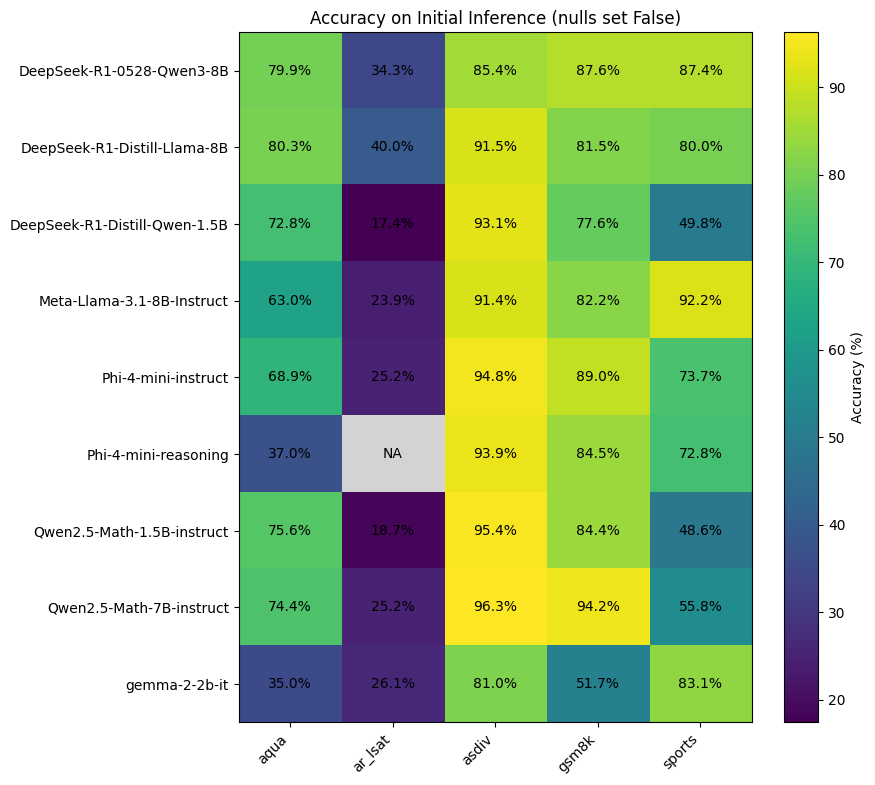

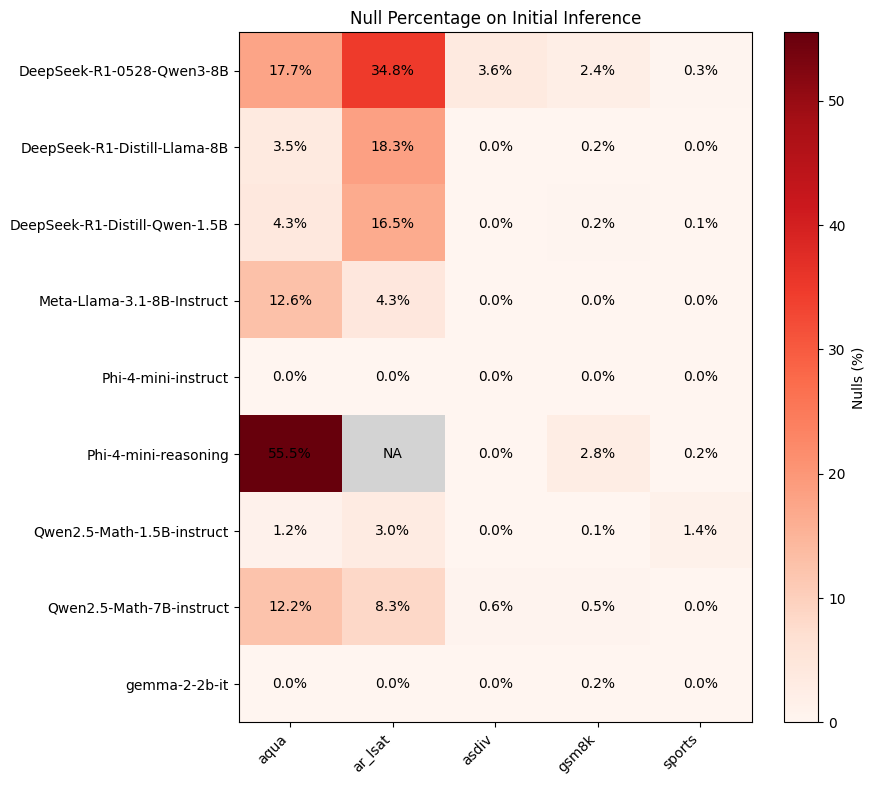

In [5]:
plot_annotated_heatmap(
    acc_mat,
    title="Accuracy on Initial Inference (nulls set False)",
    cbar_label="Accuracy (%)",
    cmap=plt.cm.viridis,
    fmt="{:.1f}%"   # writes "84.8%"
)

plot_annotated_heatmap(
    null_mat,
    title="Null Percentage on Initial Inference",
    cbar_label="Nulls (%)",
    cmap=plt.cm.Reds,
    fmt="{:.1f}%"
)
